In [1]:
#%load_ext autotime
import hanford.paths
import yaml
import os
import copy
import numpy as np
import numpy.random as npr
import scipy.optimize as spo
import scipy.linalg as spl
from matplotlib import pyplot as plt, path as mpath, collections as mc, patches as mpatches, cm, ticker
from mpl_toolkits.axes_grid1 import make_axes_locatable
from sdfs.geom_mrst import GeomMRST
from sdfs.bc_mrst import BCMRST
from sdfs.darcy import DarcyExp
from sdfs.tpfa import TPFA
from sdfs.dasa import DASAExpKL, DASAExpKLAMPS
from time import perf_counter
import ckli.mapest as mapest
import ckli.ckliest_h1reg as ckliest
import h5py
import GPy

In [2]:
plt.rc('text', usetex=True)
plt.rc('image', cmap='plasma')

def plot_patch(patches, values, fig, ax, points, title, cmin=None, cmax=None, cb=False):
    p = mc.PatchCollection(patches, cmap=cm.jet)
    p.set_array(values)
    p.set_clim([cmin, cmax])
    ax.add_collection(p)
    if points is not None:
        ax.plot(*points, 'ko', markersize=0.5)
    ax.set_aspect('equal')
    ax.axis('off')
    ax.autoscale(tight=True)
    #ax.set_title(title)
    if cb:
        fig.colorbar(p, ax=ax)
    return p

In [3]:
# Parameters
num_trials = 1
seed = 0
#Nuobs = 50
NYobs = 100
NYlearn = NYobs
NYrefobs = 50
NYxi = 1000
Nuxi = 1000
Nens = 5000
gamma_map = 1e-6
std_dev_ref = 1.0
cor_len_ref = 0.1
res_fac = 1
resolution = '64x'
resolution_ref = '1x'
resolution_iYobs = '16x'
lsq_method = 'trf'
geom_filename = f'hanford_data/geom_{resolution}.mat'
geom_ref_filename= f'hanford_data/geom_{resolution_ref}.mat'
bc_filename = f'hanford_data/bc_{resolution}.mat'
conduct_filename = f'hanford_data/conduct_log_{resolution_ref}.mat'
well_cells_filename = f'hanford_data/well_cells_{resolution}.mat'
yobs_fine_filename = f'hanford_data/yobs_{NYobs}_{resolution_iYobs}.npy'
yobs_filename = f'hanford_data/yobs_{NYobs}_{resolution}.npy'
geom_fine_filename = f'hanford_data/geom_{resolution_iYobs}.mat'
ref = f'Yref=orig_interpolated_{resolution}'

In [4]:
Yfac = 7.0 # Rescaling factor for log-conductivity. Must be applied to Yref and the BCs

geom = GeomMRST(geom_filename)
if resolution_ref != resolution:
    geom_ref = GeomMRST(geom_ref_filename)
else:
    geom_ref = geom
bc = BCMRST(geom, bc_filename)
bc.rescale('N', Yfac)

In [5]:
patches = [mpatches.Polygon(v, closed=True) for v in geom.nodes.coords.T[geom.cells.nodes.T, :]]
patches_ref = [mpatches.Polygon(v, closed=True) for v in geom_ref.nodes.coords.T[geom_ref.cells.nodes.T, :]]

In [6]:
# Observations
rs = npr.RandomState(seed)
Nc = geom.cells.num
Ninf = geom.faces.num_interior

with h5py.File(conduct_filename, 'r') as f:
    Yref_orig = f.get('conduct_log')[:].ravel() - Yfac

In [7]:
rl2e = lambda yest, yref : spl.norm(yest - yref, 2) / spl.norm(yref, 2)
infe = lambda yest, yref : spl.norm(yest - yref, np.inf)

In [8]:
if os.path.exists(yobs_fine_filename):
    geom_fine = GeomMRST(geom_fine_filename)
    print(f'reading {yobs_filename}')
    iYobs_fine = np.load(yobs_fine_filename)
    print(f'{iYobs_fine.shape=}')
    iYobs = np.array([geom.anyCellsWithin(geom_fine.nodes.coords.T[geom_fine.cells.nodes.T[iYobs_fine[t]]]) for t in range(num_trials)])
    np.save(yobs_filename, iYobs)
    iYobs_ref = np.array([geom_ref.cellsContain(geom_fine.cells.centroids.T[iYobs_fine[t]]) for t in range(num_trials)])
elif os.path.exists(yobs_filename):
    iYobs = np.load(yobs_filename)
    iYobs_ref = np.array([geom_ref.cellsContain(geom.cells.centroids.T[iYobs[t]]) for t in range(num_trials)])
#    iYobs_fine = np.load(yobs_filename)
#    if iYobs_fine.ndim != 1:
#        iYobs_fine = iYobs_fine[0]
else:
    print("iYobs randomly generated")
    iYobs_fine = rs.choice(geom_fine.cells.num, NYobs, replace=False)

iYlearn = iYobs_ref
Ylearn = np.array([Yref_orig[iYlearn[t]] for t in range(num_trials)])

reading hanford_data/yobs_100_64x.npy
iYobs_fine.shape=(10, 100)


In [9]:
timings = np.zeros((num_trials, 6))
nfevs = np.zeros((num_trials, 3), dtype=int)
rel_errors = np.zeros((num_trials, 4))
abs_errors = np.zeros((num_trials, 4))

Yref = np.zeros((num_trials, Nc))
CYref = np.zeros((num_trials, Nc, Nc))
Yobs = np.zeros((num_trials, NYobs))
Ypred = np.zeros((num_trials, Nc))
CYpred = np.zeros((num_trials, Nc, Nc))
umean = np.zeros((num_trials, Nc))
Cu = np.zeros((num_trials, Nc, Nc))
upred = np.zeros((num_trials, Nc))
Cupred = np.zeros((num_trials, Nc, Nc))

PsiY = np.zeros((num_trials, Nc, NYxi))
LambdaY = np.zeros((num_trials, NYxi))
Psiu = np.zeros((num_trials, Nc, Nuxi))
Lambdau = np.zeros((num_trials, Nuxi))

Yest = np.zeros((num_trials, Nc))

In [10]:
for t in range(num_trials):
    klearn = GPy.kern.sde_Matern52(input_dim=2, variance=std_dev_ref**2, lengthscale=cor_len_ref)
    mYlearn = GPy.models.GPRegression(geom_ref.cells.centroids[:, iYlearn[t]].T, Ylearn[t, :, None], klearn, noise_var=np.sqrt(np.finfo(float).eps))
    mYlearn.optimize(messages=True, ipython_notebook=False)
    mYref = GPy.models.GPRegression(geom_ref.cells.centroids.T, Yref_orig[:, None], mYlearn.kern, noise_var=np.sqrt(np.finfo(float).eps))
    Yref[t], CYref[t] = (lambda x, y : (x.ravel(), y))(*mYref.predict_noiseless(geom.cells.centroids.T, full_cov=True))

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s03  0006   1.837728e+02   2.073321e+03 
    00s07  0013   1.498496e+02   6.344707e-01 
    00s11  0021   1.487560e+02   3.094093e-02 
    00s14  0028   1.487508e+02   1.509072e-04 
    00s18  0036   1.487508e+02   5.562569e-08 
    00s19  0037   1.487508e+02   5.562569e-08 
Runtime:     00s19
Optimization status: Converged



In [ ]:
np.savetxt(f'hanford/results/Yref_{ref}.txt', Yref[0])

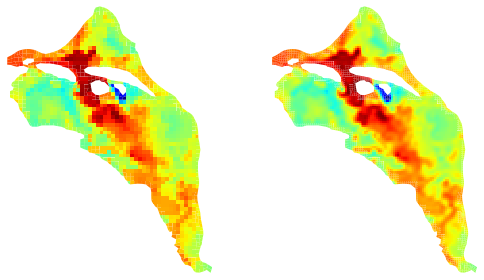

In [11]:
fig, ax = plt.subplots(1, 2, figsize=(8, 4))
plot_patch(patches_ref, Yref_orig + Yfac, fig, ax[0], None, 'Yref', 0, 12)
plot_patch(patches, Yref[0] + Yfac, fig, ax[1], None, 'Yref_4x', 0, 12)
fig.tight_layout()
fig.savefig(f'hanford/figures/Yref/Yref_{resolution_ref=}_NY={NYobs}_{resolution}.pdf', dpi=300)

In [12]:
# u observations
with h5py.File(well_cells_filename, 'r') as f:
    iuobs = f.get('well_cells')[:].ravel() - 1
Nuobs = iuobs.size

prob = DarcyExp(TPFA(geom, bc), None)

uref = np.array([prob.solve(Yref[t]) for t in range(num_trials)])
uobs = uref[:, iuobs]

(10, 5900)


In [13]:
exp = f'NY={NYobs}_Nu={iuobs.size}_{NYlearn=}_{NYxi=}_gamma={gamma_map}_cklmap_h1reg_amps_{ref}'
print(exp)

NY=100_Nu=408_NYlearn=100_NYxi=1000_gamma=1e-06_cklmap_h1reg_amps_Yref=orig_interpolated


In [14]:
for t in range(num_trials):
    iYlearn = iYobs[t]
    Ylearn = Yref[t, iYlearn]
    Yobs[t] = Yref[t, iYobs[t]]

    ts = perf_counter()
    klearn = GPy.kern.sde_Matern52(input_dim=2, variance=std_dev_ref**2, lengthscale=cor_len_ref)
    mYlearn = GPy.models.GPRegression(geom.cells.centroids[:, iYlearn].T, Ylearn[:, None], klearn, noise_var=np.sqrt(np.finfo(float).eps))
    mYlearn.optimize(messages=True, ipython_notebook=False)
    mYref = GPy.models.GPRegression(geom.cells.centroids[:, iYobs[t]].T, Yobs[t, :, None], mYlearn.kern, noise_var=np.sqrt(np.finfo(float).eps))
    Ypred[t], CYpred[t] = (lambda x, y : (x.ravel(), y))(*mYref.predict_noiseless(geom.cells.centroids.T, full_cov=True))
    timings[t, 0] = perf_counter() - ts

print(f"GPR: {timings[:, 0]} s")

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s02  0005   1.821843e+02   3.331417e+03 
    00s04  0008   1.606215e+02   7.354210e+02 
    00s06  0012   1.498698e+02   1.442644e+01 
    00s13  0023   1.490316e+02   3.740912e-03 
    00s16  0028   1.490223e+02   9.171626e-03 
    00s18  0032   1.490218e+02   9.930467e-06 
    00s21  0040   1.490218e+02   8.472584e-05 
Runtime:     00s21
Optimization status: Converged

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s01  0003   1.893534e+02   2.016575e+04 
    00s06  0011   1.482892e+02   1.578020e+01 
    00s10  0019   1.476501e+02   7.747584e-03 
    00s16  0030   1.476189e+02   1.698921e-04 
    00s19  0037   1.476674e+02   1.872010e+01 
    00s22  0045   1.476187e+02   1.706181e-09 
Runtime:     00s22
Optimization status: Converged

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s00  

In [15]:
# PICKLE models
Ym = Ypred
CYm = CYpred

rel_errors[:, 0] = np.array([rl2e(Ym[t], Yref) for t in range(num_trials)])
abs_errors[:, 0] = np.array([infe(Ym[t], Yref) for t in range(num_trials)])

print(f"GPR\tRelative error: {rel_errors[:, 0]}")
print(f"GPR\tInfinity error: {abs_errors[:, 0]}")

GPR	Relative error: [0.53662188 0.60647556 0.50927255 0.55574001 0.48706949 0.55233943
 0.55674446 0.62143528 0.70103205 0.57965587]
GPR	Infinity error: [4176.32509073 4796.51838046 4079.4292446  4469.20522363 3816.57625879
 4114.21441502 4227.90105023 4399.00236645 5012.70684306 4200.33367255]


In [16]:
for t in range(num_trials):
    ts = perf_counter()
    PsiY[t], LambdaY[t] = ckliest.KL_via_eigh(CYm[t], NYxi)
    timings[t, 2] = perf_counter() - ts

print(f"eigendecomposition: {timings[:, 2]} s")

eigendecomposition: [15.28381716 15.56836165 15.78642773 15.42926873 16.91954412 15.7429962
 15.67114614 15.56482009 15.38397838 15.2963188 ] s


In [17]:
# CKL-MAP H1 estimate
Lreg = mapest.compute_Lreg(geom)
for t in range(num_trials):
    prob.setup_amps(iuobs)
    loss = mapest.LossVec(Nc, Nc, iuobs, uobs[t], iYobs[t], Yobs[t], gamma_map, Lreg) # H1 regularization
    #dasa = DASAExpKL(loss.val, loss.grad_u, loss.grad_Y, prob.solve, prob.residual_sens_u, prob.residual_sens_Y, Ym[t], PsiY[t])
    dasa = DASAExpKLAMPS(loss.val, loss.grad_u, loss.grad_Y, prob.partial_solve, prob.residual_sens_u, prob.residual_sens_Y, Ym[t], PsiY[t], prob.u_sens_p, (Nuobs + NYobs + Ninf, NYxi), Nuobs)
    ts = perf_counter()
    sol = spo.least_squares(dasa.obj, np.zeros(NYxi), jac=dasa.grad, method=lsq_method, verbose=2)
    Yest[t] = Ym[t] + PsiY[t] @ sol.x
    MAP_status = sol.status
    timings[t, 4] = perf_counter() - ts
    nfevs[t, 1] = sol.nfev
    print(f'CKL-MAP status: {MAP_status}, message: {sol.message}')

rel_errors[:, 2] = np.array([rl2e(Yest[t], Yref[t]) for t in range(num_trials)])
abs_errors[:, 2] = np.array([infe(Yest[t], Yref[t]) for t in range(num_trials)])

print(f"CKL-MAP: {timings[:, 4]} s")
print(f"CKL-MAP relative L2 error: {rel_errors[:, 2]}")
print(f"CKL-MAP absolute infinity error: {abs_errors[:, 2]}")

5       2.00e+00       2.82e-02    
      22             27         7.3327e-04      3.80e-05       2.00e+00       2.08e-02    
      23             28         7.0200e-04      3.13e-05       2.00e+00       1.83e-02    
      24             29         6.7171e-04      3.03e-05       2.00e+00       1.84e-02    
      25             30         6.4598e-04      2.57e-05       2.00e+00       1.70e-02    
      26             31         6.2529e-04      2.07e-05       2.00e+00       1.47e-02    
      27             32         6.0824e-04      1.71e-05       2.00e+00       1.18e-02    
      28             33         5.9408e-04      1.42e-05       2.00e+00       8.74e-03    
      29             35         5.8502e-04      9.06e-06       1.00e+00       1.65e-03    
      30             36         5.7770e-04      7.32e-06       2.00e+00       4.94e-03    
      31             37         5.7723e-04      4.68e-07       4.00e+00       1.41e-02    
      32             38         5.5958e-04      1.76e-

In [19]:
np.savetxt(f'hanford/results/iYobs/iYobs_{exp}.txt', iYobs.astype(int), fmt='%i')
np.savetxt(f'hanford/results/timings/timings_{exp}.txt', timings)
np.savetxt(f'hanford/results/nfevs/nfevs_{exp}.txt', nfevs.astype(int), fmt='%i')
np.savetxt(f'hanford/results/rel_errors/rel_errors_{exp}.txt', rel_errors)
np.savetxt(f'hanford/results/abs_errors/abs_errors_{exp}.txt', abs_errors)
np.savetxt(f'hanford/results/YGPR/YGPR_{exp}.txt', Yref)
np.savetxt(f'hanford/results/YMAP/YMAP_{exp}.txt', Yest)

In [20]:
t = 0

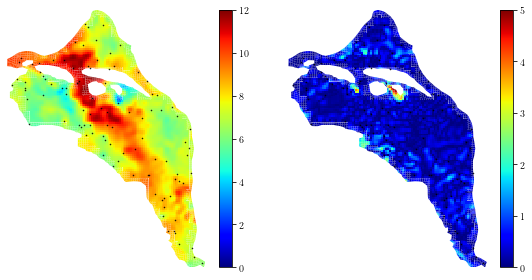

In [21]:
fig, ax = plt.subplots(1, 2, figsize=(8, 4))

plot_patch(patches, Yest[t] + Yfac, fig, ax[0], geom.cells.centroids[:, iYobs[t]], 'Yest_CKL-MAP', 0, 12, True)
plot_patch(patches, np.abs(Yest[t] - Yref[t]), fig, ax[1], geom.cells.centroids[:, iYobs[t]], '|Yest_CKL-MAP - Yref|', 0, 5, True)

fig.tight_layout()